<h1>Appendix E: AntoEncoder with Tensorflow analyzing multi-column single sensor data

In [1]:
#pip install pandas==2.0.3
#pip install numpy==1.21 --user
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt 
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
# Read the CSV data into a Pandas DataFrame
df = pd.read_csv('D:\\Download\\Tool_Sensor_Data.csv')
print(df.shape)
df.head()

(14844, 90)


,TimeStamp,ToolName,TOOL_ID,Run,RunStartTime,DATA_QUALITY,EQPType,HasComments,LOT_ID,LogicalRecipeID,...,yqScxEFPLde,jrsnDLYHnMHD,CalcStepSeq,CalcLoopSeq,RunTag,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89
0,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# All data cleaning processes in one Cell
# Will not use TimeStamp and consider it as 1,2,3 series of data
if 'TimeStamp' in df.columns:
    df = df.drop('TimeStamp', axis=1)
if 'RunStartTime' in df.columns:
    df = df.drop('RunStartTime', axis=1)

# Unsure if ToolName, RecipeID is useful or not, just convert the character into integer
# Define the function to convert character to number
def char_to_num(char):
    return ord(char) - 64

single_char_columns = [col for col in df.columns if all(len(str(val)) == 1 for val in df[col])]
#print(single_char_columns)

for column in single_char_columns:
    #print(df[column].dtypes)
    if df[column].dtypes == 'object':
        df[column] = df[column].apply(char_to_num)
        
# Verify if those columns are not useful, drop it
# Find/Validate if any more non-integer columns
for column in df.columns:
    if df[column].dtypes == 'object':
        #print(column, df[column].dtypes)
        print("  ", df[column].iloc[0])
for column in df.columns:
    if df[column].dtypes == 'object':
        print(column, df[column].dtypes, 'DROP')
        #print("  ", df[column].iloc[0], 'DROP')
        df = df.drop(column, axis=1)

# Remove empty/almost empty rows
non_empty_columns_per_row = df.count(axis=1)
x_data = list(range(1, len(non_empty_columns_per_row) + 1))
# set half as the threshold
threshold = len(df.columns)/2
print(threshold)
# Remove empty rows below threshold
print('Before remove=',df.shape)
df = df.dropna(thresh=threshold)
print('After remove=',df.shape)

print(df.shape)
df = df.drop_duplicates()
print(df.shape)

# Remove Useless Columns
# Fill in empty cell?
df = df.fillna(0)
column_stddev = {}
for column in df.columns:
    std_deviation = df[column].std()
    #print(column, std_deviation)
    if std_deviation == 0:
        #print(column, std_deviation, "DROP")
        df = df.drop(column, axis=1)
        #df.drop(column, inplace=True, axis=1)
    else:
        column_stddev[column]=std_deviation
        
print(df.shape)
df_bak=df

25.5
Before remove= (13652, 51)
After remove= (13652, 51)
(13652, 51)
(13652, 51)
(13652, 51)


In [7]:
# Get unique run numbers 
runs = df['Run'].unique()
print('Total Unique Runs=',len(runs))
#runs

df_run = pd.DataFrame()
i=0
# Calculate each Run's lenght and record inside df_run
for run in runs:
    count = (df['Run'] == run).sum()
    df_run.loc[i, 'Run'] = run
    df_run.loc[i, 'Count'] = count
    i=i+1
    #print(run,count)
df_run.head()

Total Unique Runs= 228


,Run,Count
0,62301.0,57.0
1,62302.0,63.0
2,62303.0,56.0
3,62304.0,51.0
4,62305.0,60.0


In [8]:
# remove all columns except one
check_column = 'SwpYipezsdueC'
for column in df.columns:
    #if column != 'ETcatZBXS' and column != 'Run':
    if column != check_column and column != 'Run':
        #print(column,"DROP")
        df=df.drop(column, axis=1)
print(df.shape)
print(df.head())
# Split data into dicts by run number
data_by_run = {run: df[df['Run'] == run] for run in runs}

(13652, 2)
     Run  SwpYipezsdueC
1  62301          125.0
2  62301          123.0
3  62301          123.0
4  62301          123.0
5  62301          123.0


In [9]:
# Get the max lenght for resampling
new_df = pd.DataFrame()
i=0
mydict={}
for run, df1 in data_by_run.items():
    #print(f"Run {run}")
    i = i + 1
    mylist = df1[check_column].tolist()
    mydict[run]=len(mylist)

#for key, value in mydict.items():
    #print(key, ":", value)
max_key = max(mydict, key=lambda key: mydict[key])
max_value = mydict[max_key]
print('Maximum Run record lenght =', max_value)

Maximum Run record lenght = 87


In [10]:
# CONVERT the time series row to column, RESAMPLE and put into new dataframe
new_df = pd.DataFrame()
i=0
for run, df1 in data_by_run.items():
    #print(f"Run {run}")
    i = i + 1
    mylist = df1[check_column].tolist()
    #mylist = df1['ETcatZBXS'].tolist()
    # Resample mylist using linear interpolation to match the length of the longer list
    if len(mylist) < max_value:
        x1 = np.arange(len(mylist))
        x2 = np.linspace(0, len(mylist) - 1, max_value)
        mylist = np.interp(x2, x1, mylist)
    mylist = np.insert(mylist, 0, run)
    new_row = pd.DataFrame([mylist])
    #new_df = new_df.append(new_row, ignore_index=True)
    new_df = pd.concat([new_df, new_row], ignore_index=True)
new_df.set_index(0, inplace=True)
new_df

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
62301.0,125.0,123.697674,123.00000,123.000000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.000000,137.0
62302.0,120.0,120.000000,120.00000,120.000000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,139.000000,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.441860,136.0
62303.0,121.0,121.000000,121.00000,121.000000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.000000,137.0
62304.0,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.232558,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
62305.0,120.0,120.000000,120.00000,119.941860,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,139.825581,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.000000,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62596.0,124.0,124.000000,124.00000,124.000000,124.232558,124.790698,125.000000,125.000000,125.465116,126.000000,...,139.000000,138.465116,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
62597.0,120.0,120.000000,120.00000,119.906977,119.209302,119.000000,119.186047,119.883721,120.000000,120.000000,...,140.000000,140.000000,139.883721,139.186047,139.000000,138.790698,138.093023,138.000000,138.000000,138.0
62598.0,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.546512,...,139.000000,138.930233,138.313953,138.000000,138.000000,137.465116,137.000000,137.000000,136.616279,136.0


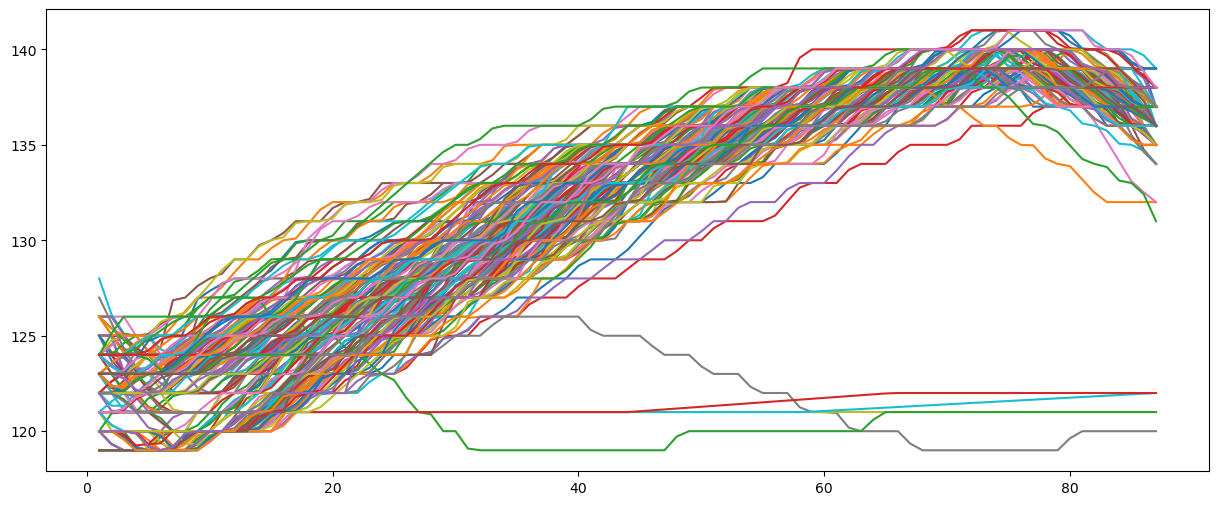

In [11]:
plt.figure(figsize=(15, 6))
for index, row in new_df.iterrows():
    plt.plot(row, label=f'Line {index}')  # Plot each row with a label
plt.show()
#time_df['Sensor'].plot()

In [13]:
df=new_df.copy()
df

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
62301.0,125.0,123.697674,123.00000,123.000000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.000000,137.0
62302.0,120.0,120.000000,120.00000,120.000000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,139.000000,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.441860,136.0
62303.0,121.0,121.000000,121.00000,121.000000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.000000,137.0
62304.0,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.232558,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
62305.0,120.0,120.000000,120.00000,119.941860,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,139.825581,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.000000,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62596.0,124.0,124.000000,124.00000,124.000000,124.232558,124.790698,125.000000,125.000000,125.465116,126.000000,...,139.000000,138.465116,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
62597.0,120.0,120.000000,120.00000,119.906977,119.209302,119.000000,119.186047,119.883721,120.000000,120.000000,...,140.000000,140.000000,139.883721,139.186047,139.000000,138.790698,138.093023,138.000000,138.000000,138.0
62598.0,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.546512,...,139.000000,138.930233,138.313953,138.000000,138.000000,137.465116,137.000000,137.000000,136.616279,136.0


In [14]:
no_index = df.copy()
no_index = no_index.reset_index(drop=True)
no_index

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,125.0,123.697674,123.00000,123.000000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.000000,137.0
1,120.0,120.000000,120.00000,120.000000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,139.000000,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.441860,136.0
2,121.0,121.000000,121.00000,121.000000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.000000,137.0
3,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.232558,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
4,120.0,120.000000,120.00000,119.941860,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,139.825581,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.000000,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,124.0,124.000000,124.00000,124.000000,124.232558,124.790698,125.000000,125.000000,125.465116,126.000000,...,139.000000,138.465116,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
224,120.0,120.000000,120.00000,119.906977,119.209302,119.000000,119.186047,119.883721,120.000000,120.000000,...,140.000000,140.000000,139.883721,139.186047,139.000000,138.790698,138.093023,138.000000,138.000000,138.0
225,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.546512,...,139.000000,138.930233,138.313953,138.000000,138.000000,137.465116,137.000000,137.000000,136.616279,136.0
226,121.0,121.000000,121.00000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.534884,...,141.000000,141.000000,141.000000,141.000000,140.186047,140.000000,140.000000,139.674419,138.837209,138.0


In [261]:
#!pip install tensorflow

In [18]:
#!pip install tensorflow==2.6.0
#pip install keras==2.6.0 --user
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [19]:
index_variable = df.index
index_variable = index_variable.astype(int)
data = df.copy()
data = data.reset_index(drop=True)
#data['value'].values.reshape(-1, 1)

In [20]:
data

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,125.0,123.697674,123.00000,123.000000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.000000,137.0
1,120.0,120.000000,120.00000,120.000000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,139.000000,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.441860,136.0
2,121.0,121.000000,121.00000,121.000000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.000000,137.0
3,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.232558,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
4,120.0,120.000000,120.00000,119.941860,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,139.825581,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.000000,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,124.0,124.000000,124.00000,124.000000,124.232558,124.790698,125.000000,125.000000,125.465116,126.000000,...,139.000000,138.465116,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
224,120.0,120.000000,120.00000,119.906977,119.209302,119.000000,119.186047,119.883721,120.000000,120.000000,...,140.000000,140.000000,139.883721,139.186047,139.000000,138.790698,138.093023,138.000000,138.000000,138.0
225,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.546512,...,139.000000,138.930233,138.313953,138.000000,138.000000,137.465116,137.000000,137.000000,136.616279,136.0
226,121.0,121.000000,121.00000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.534884,...,141.000000,141.000000,141.000000,141.000000,140.186047,140.000000,140.000000,139.674419,138.837209,138.0


In [21]:
# Normalize the data, and try not to normalize
#print(data)
#scaler = StandardScaler()
#data = scaler.fit_transform(data)
print(data.shape)
print(type(data))
# Try without scaling
data = data.to_numpy()

# Split the data into train and test sets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# Build the autoencoder model
input_dim = X_train.shape[1]
print(input_dim)
encoding_dim = 32

(228, 87)
<class 'pandas.core.frame.DataFrame'>
87


In [22]:
# Setup standard AutoEncoder method
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder = keras.layers.Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = keras.models.Model(inputs=input_layer, outputs=decoder)

In [23]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
#autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, batch_size=16, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/20
12/12 [==============================] - 1s 21ms/step - loss: 17234.4707 - val_loss: 17178.2383
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 17216.9492 - val_loss: 17163.4160
Epoch 3/20
12/12 [==============================] - 0s 5ms/step - loss: 17208.6406 - val_loss: 17160.6055
Epoch 4/20
12/12 [==============================] - 0s 5ms/step - loss: 17203.3438 - val_loss: 17151.2520
Epoch 5/20
12/12 [==============================] - 0s 4ms/step - loss: 17197.3828 - val_loss: 17151.2422
Epoch 6/20
12/12 [==============================] - 0s 4ms/step - loss: 17197.3809 - val_loss: 17151.2422
Epoch 7/20
12/12 [==============================] - 0s 4ms/step - loss: 17197.1191 - val_loss: 17148.4297
Epoch 8/20
12/12 [==============================] - 0s 4ms/step - loss: 17192.1406 - val_loss: 17145.5430
Epoch 9/20
12/12 [==============================] - 0s 6ms/step - loss: 17191.6738 - val_loss: 17145.5410
Epoch 10/20
12/12 [==========================

In [24]:
# Use the trained autoencoder for anomaly detection
predictions = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - predictions, 2), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 90)  # Adjust the percentile as needed

# Identify anomalies
anomalies = X_test[reconstruction_error > threshold]

print(anomalies.shape)
#anomalies

(5, 87)


In [25]:
# Use the trained autoencoder for anomaly detection
predictions = autoencoder.predict(data)
reconstruction_error = np.mean(np.power(data - predictions, 2), axis=1)
predictions_df=pd.DataFrame(predictions)
predictions_df

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,3.990084e-37,7.149370e-18,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.039393e-35,3.809929e-18,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.372152e-36,4.728149e-18,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.196593e-36,1.031746e-17,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
4,1.0,0.0,0.0,1.0,1.0,1.0,1.0,3.877370e-35,5.295903e-18,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,1.0,0.0,0.0,1.0,1.0,1.0,1.0,9.740594e-38,5.725733e-18,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
224,1.0,0.0,0.0,1.0,1.0,1.0,1.0,3.102296e-35,3.988479e-18,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
225,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.061717e-36,1.284543e-17,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
226,1.0,0.0,0.0,1.0,1.0,1.0,1.0,7.497382e-36,3.712512e-18,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [26]:
# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 90)  # Adjust the percentile as needed
print(threshold)
#reconstruction_error

17580.549751807433


In [27]:
# Identify anomalies
anomalies = data[reconstruction_error > threshold]

print(anomalies.shape)
#anomalies
data
data_df=pd.DataFrame(data)
#data_df

(23, 87)


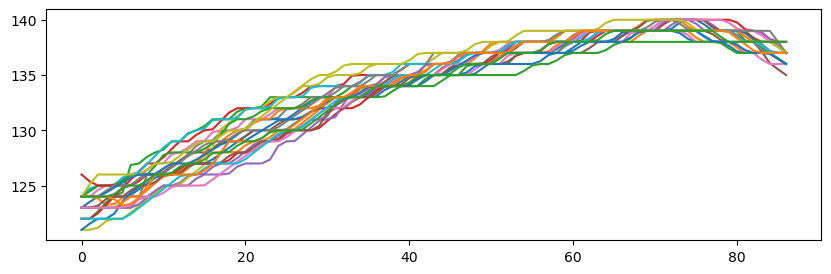

In [28]:
plt.figure(figsize=(10, 3))
anomalies_df=pd.DataFrame(anomalies)
for index, row in anomalies_df.iterrows():
    plt.plot(row, label=f'Line {index}')  # Plot each row with a label
plt.show()

<h4>The anomalies detected does not look abnormal

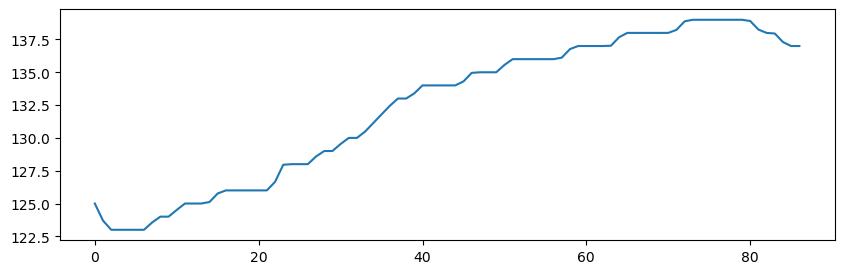

In [31]:
# This is the first sensor data with normal pattern
list0=data[0]
plt.figure(figsize=(10, 3))
plt.plot(list0)

<h2>Conclusion: The method above does not work well

In [ ]:
# Below is sample code for reference only

In [ ]:
# Sample code
from keras.layers import Input, Dense
from keras.models import Model

   input_dim = X_train.shape[1]
   encoding_dim = 32

   input_layer = Input(shape=(input_dim,))
   encoder = Dense(encoding_dim, activation='relu')(input_layer)
   decoder = Dense(input_dim, activation='sigmoid')(encoder)

   autoencoder = Model(input_layer, decoder)
   autoencoder.compile(optimizer='adam', loss='mean_squared_error')
   autoencoder.fit(X_train, X_train, epochs=10, batch_size=32)

In [ ]:
#Reference:https://keras.io/examples/timeseries/timeseries_anomaly_detection/